In [1]:
# print('NOTE: Intentionally crashing session to use the newly installed library.\n')

# !pip uninstall -y pyarrow
# !pip install ray[debug]==0.7.5
# !pip install bs4

# # A hack to force the runtime to restart, needed to include the above dependencies.
# import os
# #os._exit(0)
# !pip install -U ipykernel
# !pip install modin[all]

In [2]:
import os
os.environ["MODIN_ENGINE"] = "ray"
import modin.pandas as pd
import numpy as np #Manejo de matrices y vectores
import scipy as sp #libreria para data science
#import pandas as pd #Manejo de iformacióón
import matplotlib.pyplot as plt #Visualización
import seaborn as sns #Visualización
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

**Carga de datos**

In [3]:
%time
df_application = pd.read_csv('/content/application_record.csv', encoding = 'utf-8')
df_record = pd.read_csv('/content/credit_record.csv', encoding = 'utf-8')   

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



In [4]:
%time
df_application.head()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
%time
df_record.head()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Pre-Procesamiento (limpieza)**

In [6]:
# Análisis de valores duplicados
## Id's únicos dentro del dataframe df_application
%time
print("Cantidad de registros dentro de df_data:",df_application.shape[0])
print("Cantidad de id's únicos dentro de df_data",df_application['ID'].nunique())
## NO coincide la cantidad de registros únicos con la cantidad de registros dentro
## del dataframe

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs
Cantidad de registros dentro de df_data: 438557
Cantidad de id's únicos dentro de df_data 438510


In [7]:
## Los valores duplicados dentro del dataset serán eliminados
df_application = df_application.drop_duplicates('ID', keep='last') 

In [8]:
## Id's únicos dentro del dataframe df_record
%time
print("Cantidad de registros dentro de df_record:",df_record.shape[0])
print("Cantidad de id's únicos dentro de df_record",df_record['ID'].nunique())
# NO coincide la cantidad de registros únicos con la cantidad de registros dentro
# porque son datos mensuales

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
Cantidad de registros dentro de df_record: 1048575
Cantidad de id's únicos dentro de df_record 45985


In [9]:
## Número de id's que las dos tables comparten
%time
print(len(set(df_application["ID"]).intersection(set(df_record["ID"]))))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
36457


In [10]:
# Análisis de valores nulos df_application
%time
print("-----------Análisis de valores nulos df_application-------------------")
print(df_application.isnull().sum())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
-----------Análisis de valores nulos df_application-------------------
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64


In [11]:
# El campo OCCUPATION_TYPE tiene gran cantidad de valores nulos
# no se tomará en cuenta este campo por dicha razón
df_application.drop('OCCUPATION_TYPE', axis=1, inplace=True) 

In [12]:
# Análisis de valores nulos df_record
%time
print("-----------Análisis de valores nulos df_record-------------------")
print(df_record.isnull().sum())

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 26.9 µs
-----------Análisis de valores nulos df_record-------------------
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [13]:
# Unificación de las dos tablas
%time
#union = pd.merge(df_application, df_record, on="ID")
union = df_application.join(df_record.set_index('ID'), on='ID', how='inner')
union.info()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 777715 entries, 0 to 434812
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  -------------------  ---------------  -----  
 0   ID                   777715 non-null  int64
 1   CODE_GENDER          777715 non-null  object
 2   FLAG_OWN_CAR         777715 non-null  object
 3   FLAG_OWN_REALTY      777715 non-null  object
 4   CNT_CHILDREN         777715 non-null  int64
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object
 7   NAME_EDUCATION_TYPE  777715 non-null  object
 8   NAME_FAMILY_STATUS   777715 non-null  object
 9   NAME_HOUSING_TYPE    777715 non-null  object
 10  DAYS_BIRTH           777715 non-null  int64
 11  DAYS_EMPLOYED        777715 non-null  int64
 12  FLAG_MOBIL           777715 non-null  int64
 13  FLAG_WORK_PHONE      777715 non-null  int64
 14  FLAG_PHONE        

In [14]:
# Eliminación de columnas que no se usarán para el análisis
union.drop(columns=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

In [15]:
%time
union.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,2.0,0,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,2.0,-1,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,2.0,-2,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,2.0,-3,C
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,2.0,-4,C


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs
El 69% no tiene un vehículo


To request implementation, send an email to feature_requests@modin.org.


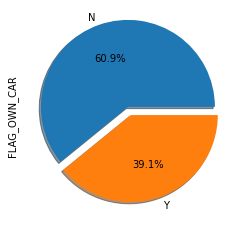

In [16]:
%time
print("El 69% no tiene un vehículo")
union['FLAG_OWN_CAR'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
Del total el 66.7% son mujeres


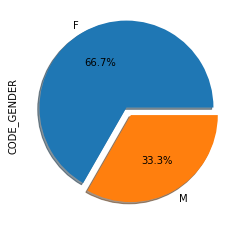

In [17]:
%time
print("Del total el 66.7% son mujeres")
union['CODE_GENDER'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

In [18]:
%time
print("La mayoría no tiene hijos")
union['CNT_CHILDREN'].value_counts()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs
La mayoría no tiene hijos


0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: CNT_CHILDREN, dtype: int64

In [19]:
%time
print("La mayoría de usuarios tiene dos familiares")
union['CNT_FAM_MEMBERS'].value_counts()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
La mayoría de usuarios tiene dos familiares


2.0     423723
1.0     141477
3.0     134894
4.0      66990
5.0       8999
6.0       1196
7.0        273
15.0       111
9.0         46
20.0         6
Name: CNT_FAM_MEMBERS, dtype: int64

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


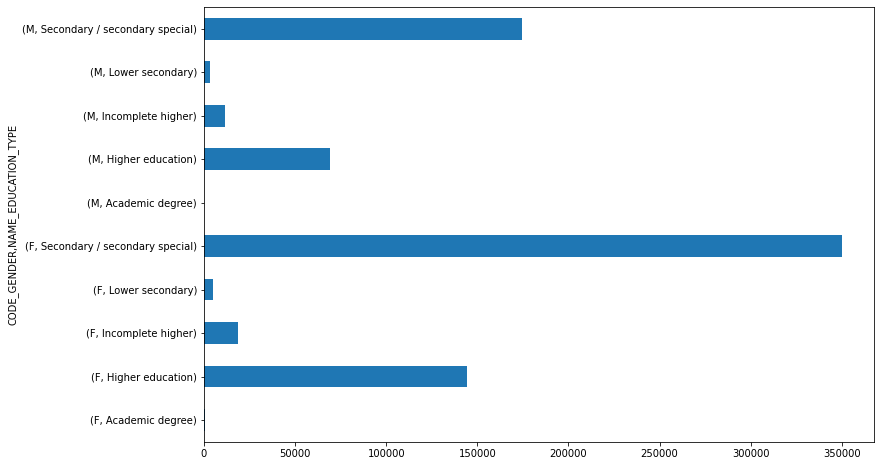

In [20]:
%time
union.groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).size().plot(kind='barh', figsize = (12, 8))

In [21]:
## Cast de datos y eliminación de filas que contengan valores nuelo
%time
union['AMT_INCOME_TOTAL'] = union['AMT_INCOME_TOTAL'].astype('int')
df_union = union.dropna()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Las familias que tienen dos hijos son las que mayor ingreso perciben


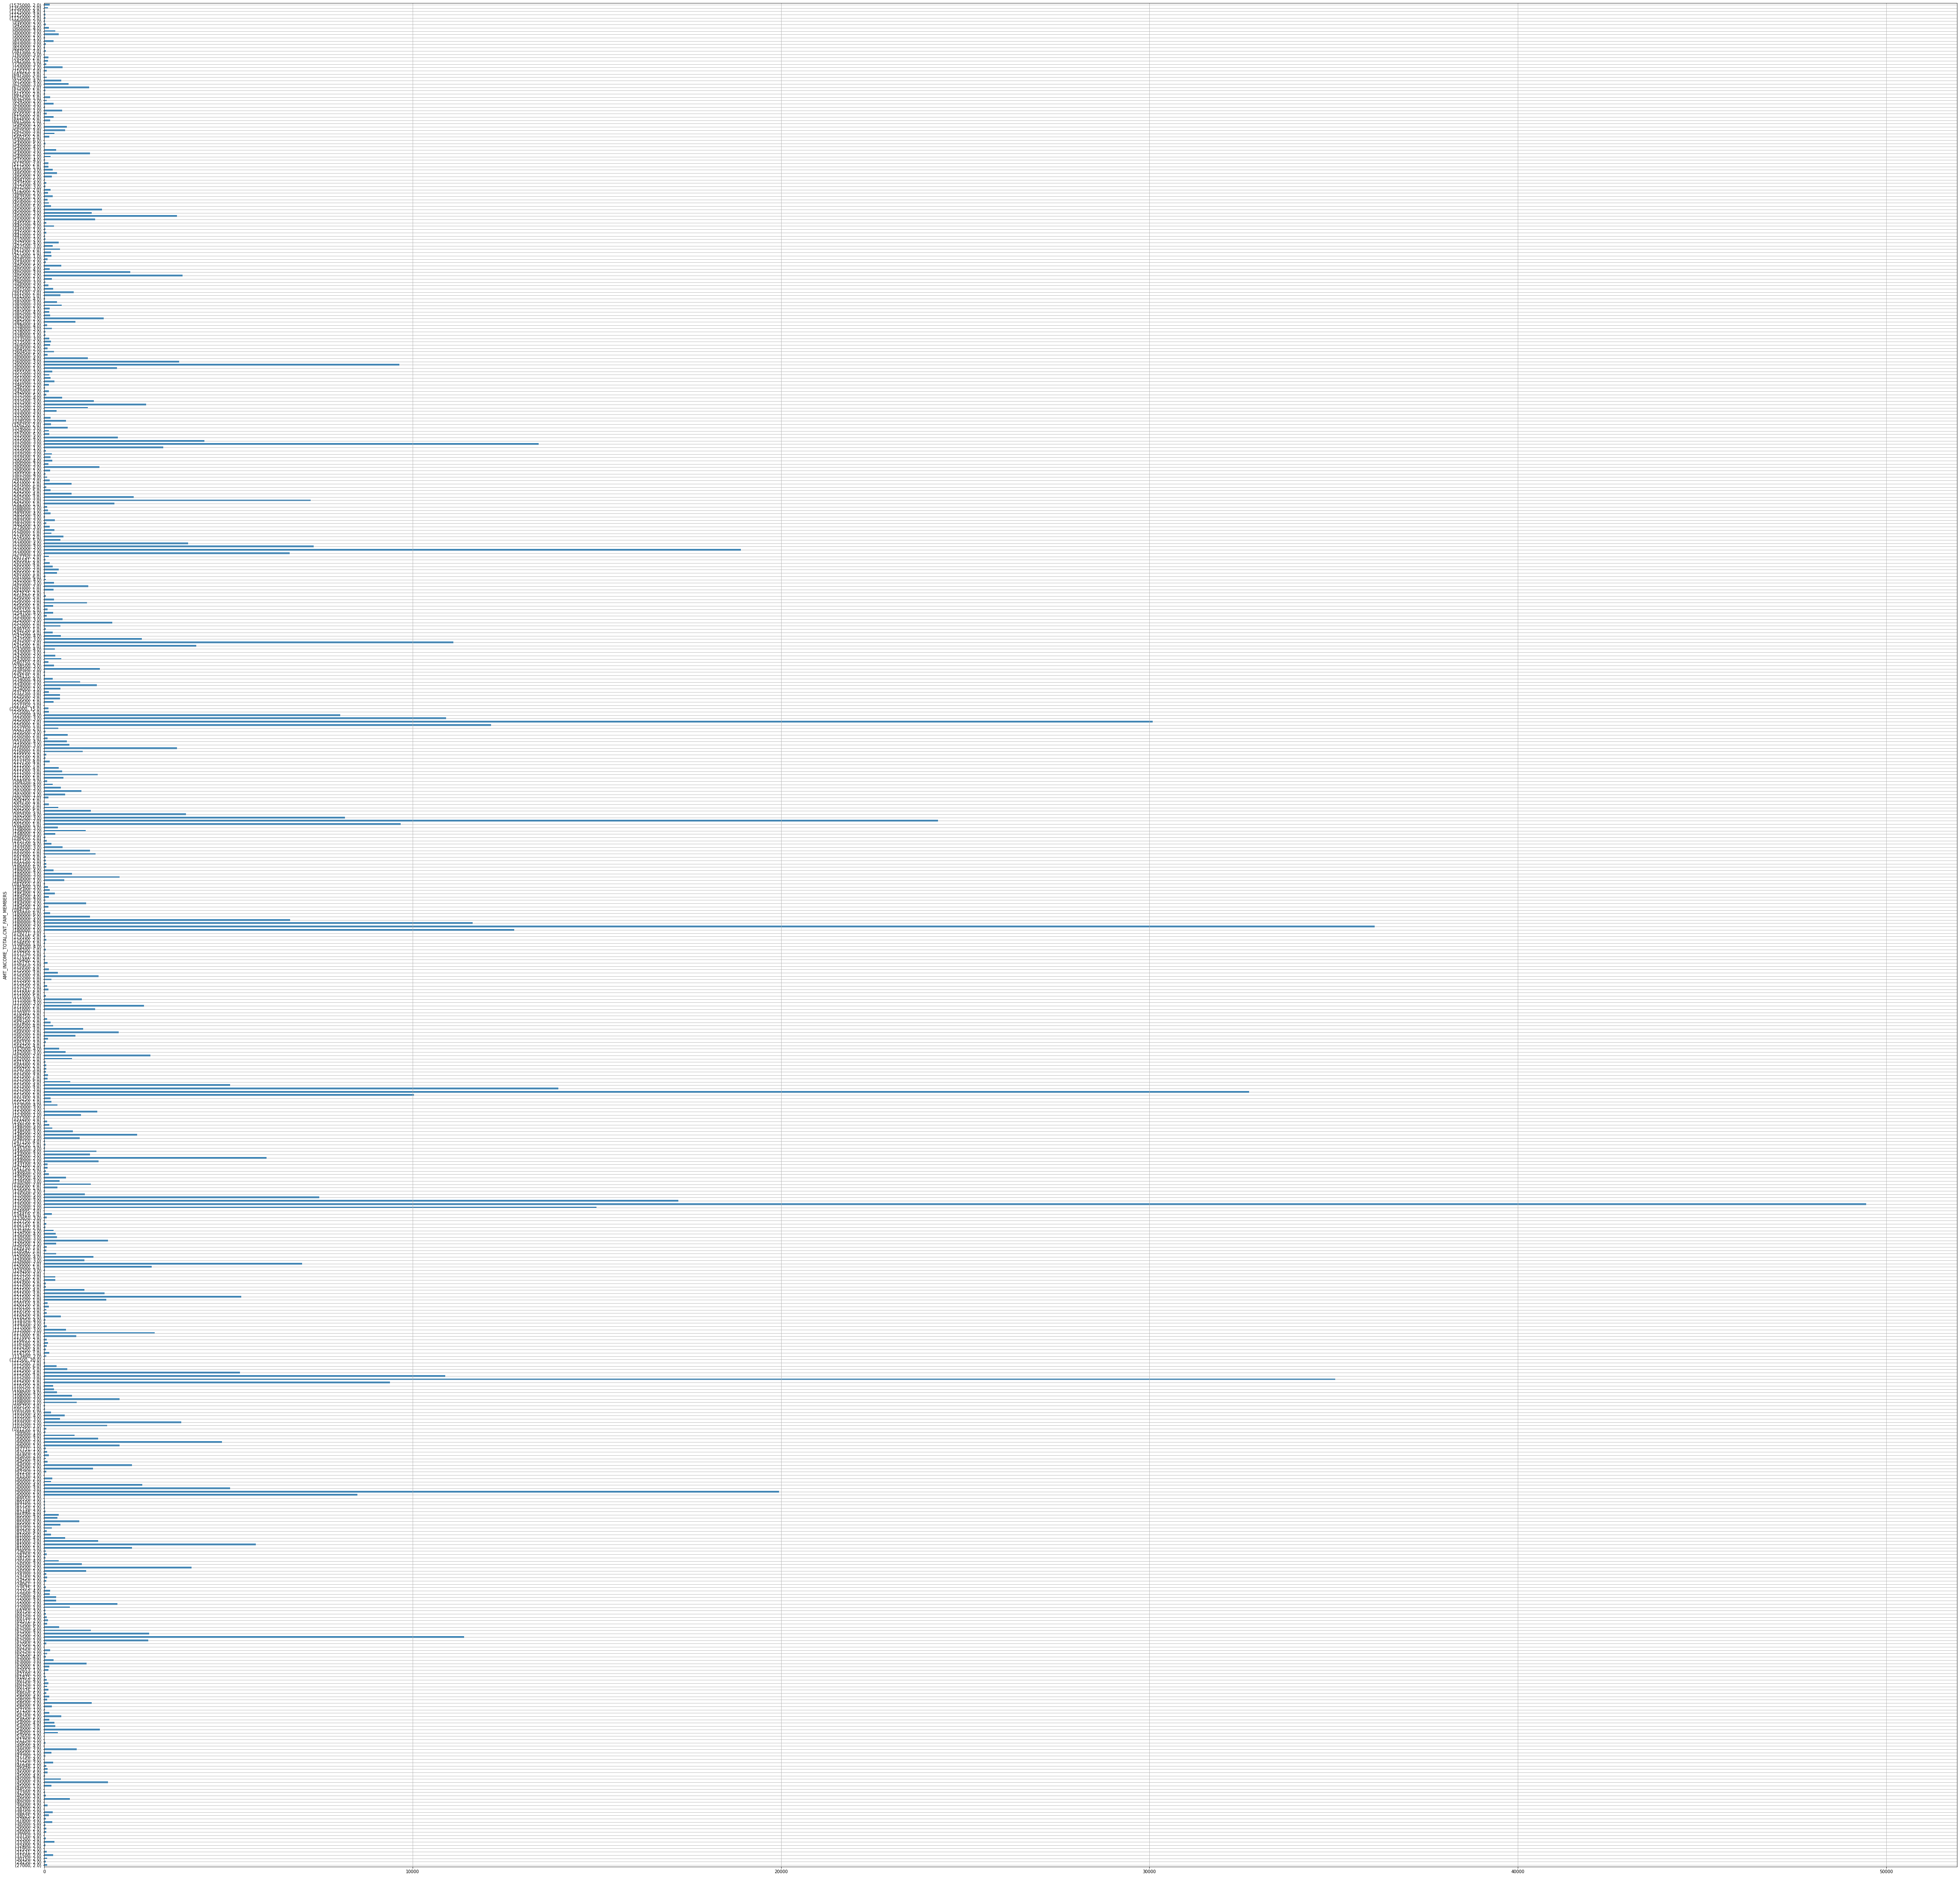

In [22]:
%time
print("Las familias que tienen dos hijos son las que mayor ingreso perciben")
df_union.groupby(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']).size().plot(kind='barh', figsize=(80, 80), grid=True)

In [23]:
%time
le = LabelEncoder()
for x in df_union:
    if df_union[x].dtypes=='object':
        df_union[x] = le.fit_transform(df_union[x])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs


In [24]:
['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


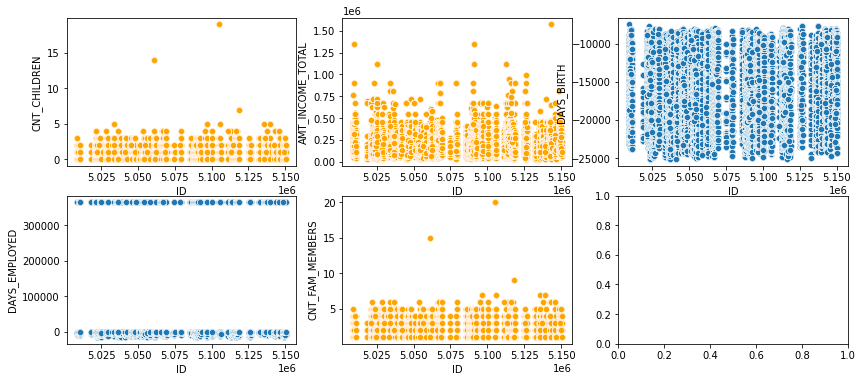

In [25]:
%time
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))
sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df_union, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df_union, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df_union, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df_union, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df_union, ax=ax[1][1], color= 'orange')

In [26]:
%time
# Existen valores atípicos en el campo CNT_CHILDREN
upper_limit = df_union['CNT_CHILDREN'].quantile(0.999)
lower_limit = df_union['CNT_CHILDREN'].quantile(0.001)
df_union = df_union[(df_union['CNT_CHILDREN']>lower_limit) & (df_union['CNT_CHILDREN']<upper_limit)]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [27]:
# Existen valores atípicos en el campo AMT_INCOME_TOTAL
upper_limit = df_union['AMT_INCOME_TOTAL'].quantile(0.999)
lower_limit = df_union['AMT_INCOME_TOTAL'].quantile(0.001)
df_union= df_union[(df_union['AMT_INCOME_TOTAL']>lower_limit) & (df_union['AMT_INCOME_TOTAL']<upper_limit)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


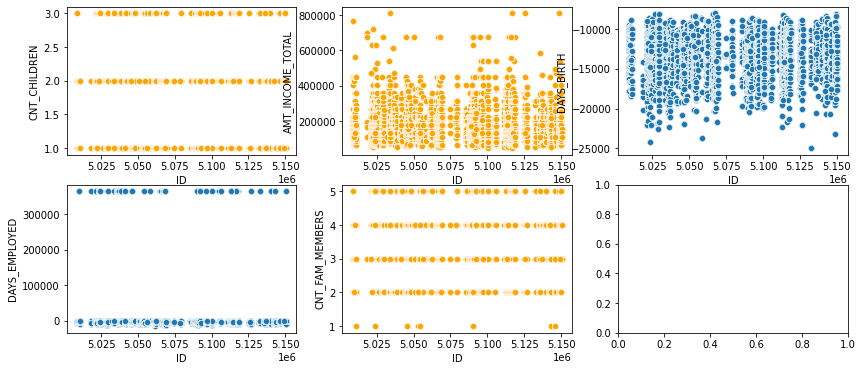

In [28]:
%time
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))
sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df_union, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df_union, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df_union, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df_union, ax=ax[1][0])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df_union, ax=ax[1][1], color= 'orange')

In [29]:
%time
df_union['Months from today'] = df_union['MONTHS_BALANCE']*-1
df_union = df_union.sort_values(['ID','Months from today'], ascending=True)
df_union.head(10)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Months from today
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,0,6,0
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-1,6,1
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-2,6,2
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-3,6,3
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-4,6,4
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-5,6,5
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-6,6,6
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-7,6,7
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-8,6,8
24,5008834,0,0,1,1,112500,4,4,3,1,-10968,-1620,2.0,-9,6,9


In [30]:
%time
df_union['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
df_union['STATUS'] = df_union['STATUS'].astype('int')
df_union['STATUS'] = df_union['STATUS'].apply(lambda x:1 if x >= 2 else 0)
df_union['STATUS'].value_counts(normalize=True) 

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


1    0.613636
0    0.386364
Name: STATUS, dtype: float64

In [32]:
%time
df_union.info()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 234005 entries, 24 to 12888
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  -------------------  ---------------  -----  
 0   ID                   234005 non-null  int64
 1   CODE_GENDER          234005 non-null  int64
 2   FLAG_OWN_CAR         234005 non-null  int64
 3   FLAG_OWN_REALTY      234005 non-null  int64
 4   CNT_CHILDREN         234005 non-null  int64
 5   AMT_INCOME_TOTAL     234005 non-null  int64
 6   NAME_INCOME_TYPE     234005 non-null  int64
 7   NAME_EDUCATION_TYPE  234005 non-null  int64
 8   NAME_FAMILY_STATUS   234005 non-null  int64
 9   NAME_HOUSING_TYPE    234005 non-null  int64
 10  DAYS_BIRTH           234005 non-null  int64
 11  DAYS_EMPLOYED        234005 non-null  int64
 12  CNT_FAM_MEMBERS      234005 non-null  float64
 13  MONTHS_BALANCE       234005 non-null  int64
 14  STATUS               2340